In [1]:
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import testkit
import ciamod
import os
import gc
import sys
import pickle
from scipy.io.idl import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import TPmod
from IPython.display import display
%matplotlib inline


In [2]:
# set up the model arguments the drop these into theta(state vector) or runargs

# set up pressure grids in bar cos its intuitive
logcoarsePress = np.arange(-4.0, 2.4, 0.53)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in bar
press = finePress
#nprof = coarsePress.size
#print nprof
print finePress.size
print finePress

64
[  1.00000000e-04   1.25892541e-04   1.58489319e-04   1.99526231e-04
   2.51188643e-04   3.16227766e-04   3.98107171e-04   5.01187234e-04
   6.30957344e-04   7.94328235e-04   1.00000000e-03   1.25892541e-03
   1.58489319e-03   1.99526231e-03   2.51188643e-03   3.16227766e-03
   3.98107171e-03   5.01187234e-03   6.30957344e-03   7.94328235e-03
   1.00000000e-02   1.25892541e-02   1.58489319e-02   1.99526231e-02
   2.51188643e-02   3.16227766e-02   3.98107171e-02   5.01187234e-02
   6.30957344e-02   7.94328235e-02   1.00000000e-01   1.25892541e-01
   1.58489319e-01   1.99526231e-01   2.51188643e-01   3.16227766e-01
   3.98107171e-01   5.01187234e-01   6.30957344e-01   7.94328235e-01
   1.00000000e+00   1.25892541e+00   1.58489319e+00   1.99526231e+00
   2.51188643e+00   3.16227766e+00   3.98107171e+00   5.01187234e+00
   6.30957344e+00   7.94328235e+00   1.00000000e+01   1.25892541e+01
   1.58489319e+01   1.99526231e+01   2.51188643e+01   3.16227766e+01
   3.98107171e+01   5.01187234e

In [21]:
w1 = 0.8
w2 = 2.4

dist = 11.35
# hardwired FWHM of data in microns
fwhm = 0.005

npatches = 1
nclouds = 1


do_clouds = np.array([1],dtype='i')


# CURRENTLY ONLY COPE WITH ONE CLOUDY PATCH.
#SO MAKE ALL CLOUD PARAMETERS THE SAME FOR EASE OF PROCESSING 

cloudnum = np.zeros([npatches,nclouds],dtype='i')
cloudnum[:,:] = 89
cloudtype = np.asfortranarray(np.ones([npatches,nclouds]),dtype='i')
cloudtype[:,:] = 2


use_disort = 0 

# use the fudge factor?
do_fudge = 1

# Set the profile type
proftype = 9

prof = np.full(13,100.)
if (proftype == 9):
    modP,modT = np.loadtxt("t1700g1000f3.dat",skiprows=1,usecols=(1,2),unpack=True)
    tfit = InterpolatedUnivariateSpline(np.log10(modP),modT,k=1)
    prof = tfit(logcoarsePress)

# now the linelist
# Set up number of gases, and point at the lists. see gaslist.dat
ngas = 9
gasnum = np.asfortranarray(np.array([1,4,7,8,9,10,11,12,20,21],dtype='i'))
lists = ["../Linelists/H2O_xsecs.pic","../Linelists/co_xsecs.pic","../Linelists/tio_xsecs.pic","../Linelists/vo_xsecs.pic","../Linelists/cah_xsecs.pic","../Linelists/crh_xsecs.pic" ,"../Linelists/feh_xsecs.pic","../Linelists/K_xsecs.pic","../Linelists/Na_xsecs.pic"]

In [4]:
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
print cloudparams.shape[2]
print cloudnum[0,0]

1
89


In [5]:
# get the basic framework from water list
rawwavenum, inpress, inlinetemps, inlinelist = pickle.load( open('../Linelists/H2O_xsecs.pic', "rb" ) )
wn1 = 10000./w2
wn2 = 10000. / w1
inwavenum = np.asfortranarray(rawwavenum[np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1)))],dtype='float64')
ntemps = inlinetemps.size
npress= finePress.size
nwave = inwavenum.size
r1 = np.amin(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))
r2 = np.amax(np.where(np.logical_not(np.logical_or(rawwavenum[:] > wn2, rawwavenum[:] < wn1))))

# Here we are interpolating the linelist onto our fine pressure scale.
# pickles have linelist as 4th entry....
linelist = (np.ones([ngas,npress,ntemps,nwave],order='F')).astype('float64', order='F')
for gas in range (0,ngas):
    inlinelist= pickle.load( open(lists[gas], "rb" ) )[3]
    # make missing bits crazy. They are all high pressure, low-temp points.
    #inlinelist[np.isnan(inlinelist)] = 1.0
    for i in range (0,ntemps):
        for j in range (r1,r2+1):
            pfit = InterpolatedUnivariateSpline(np.log10(inpress),np.log10(inlinelist[:,i,j]),k=1)
            linelist[gas,:,i,(j-r1)] = np.asfortranarray(pfit(np.log10(finePress)))

linelist[np.isnan(linelist)] = -50.0


In [6]:
print linelist

[[[[ -50.          -50.          -50.         ...,  -50.          -50.
     -50.        ]
   [ -28.86018386  -29.47120281  -28.71410754 ...,  -27.21817787
     -26.84750679  -28.33447154]
   [ -50.          -50.          -50.         ...,  -50.          -50.
     -50.        ]
   ..., 
   [ -21.41634563  -21.46745581  -21.36540888 ...,  -23.64091048
     -23.69155298  -23.63930626]
   [ -21.2606413   -21.24231024  -21.15263652 ...,  -23.55282956
     -23.55537289  -23.57502531]
   [ -21.16603227  -21.094758    -21.04712138 ...,  -23.49916411
     -23.47402149  -23.53385186]]

  [[ -50.          -50.          -50.         ...,  -50.          -50.
     -50.        ]
   [ -28.76018388  -29.37120292  -28.61410771 ...,  -27.12712206
     -26.75451777  -28.23447169]
   [ -50.          -50.          -50.         ...,  -50.          -50.
     -50.        ]
   ..., 
   [ -21.41634301  -21.46744033  -21.36538819 ...,  -23.64090928
     -23.69155208  -23.63930586]
   [ -21.2606398   -21.24230292 

In [7]:
# Get the cia bits
tmpcia, ciatemps = ciamod.read_cia("CIA_DS_aug_2015.dat",inwavenum)
cia = np.asfortranarray(np.empty((4,ciatemps.size,nwave)),dtype='float32')
cia[:,:,:] = tmpcia[:,:,:nwave] 
ciatemps = np.asfortranarray(ciatemps, dtype='float32')


In [10]:
# get the observed spectrum
obspec = np.asfortranarray(np.loadtxt("2M2224_mkoJcalib_trim.dat",dtype='d',unpack='true'))

do_fudge = 1

# place holder values for cloudparams
cloudparams = np.ones([5,npatches,nclouds],dtype='d')
cloudparams[0,:,:] = 0.
cloudparams[1,:,:] = 0.0
cloudparams[2,:,:] = 0.1
cloudparams[3,:,:] = 0.0
cloudparams[4,:] = 0.0


runargs = dist, cloudtype,cloudparams,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge,prof


In [11]:
# for proftype = 2 with no clouds, ndim = nprof + ngas-1, + (dlam,beta,logg, r2d2)
ndim =16 #(nprof + (ngas-1) + 9)
theta = np.empty(ndim)
print ndim

16


In [15]:
theta[0] = -3.16459894e+00 #(0.5*np.random.randn()) - 3.5 # H2O
theta[1] = -1.96267367e+00 #(0.5*np.random.randn()) - 6.0 # CO
theta[2] = -1.14442303e+01 #(0.5*np.random.randn()) - 8.0 # TiO
theta[3] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # VO 
theta[4] = -1.07901469e+01 #(1.0*np.random.randn()) - 8.0 # CaH
theta[5] = -7.18029425e+00 #(1.0*np.random.randn()) - 8.0 # CrH
theta[6] = -8.08165811e+00 #(0.5*np.random.randn()) - 8.0 # FeH
theta[7] = -8.08165811e+00 #(0.5*np.random.randn()) - 8.0 # FeH
theta[8] = -3.97709062e+00 #(0.5*np.random.randn()) - 5.5 # Na+K
theta[9] = 5.24787282e+00 #np.random.rand() + 4.2  # logg
theta[10] = 1e-20 +  5e-20 * np.random.rand()   # r2d2
theta[11] = 1.87727140e-03#np.random.randn() * 0.001 # dlam
theta[12] = np.log10((np.random.rand() * (max(obspec[2,:]**2)*(10. - 0.01))) + (0.01*min(obspec[2,10::3]**2)))
theta[13] = 2.0 #-15.0 # density
theta[14] = -4. + 6.*np.random.rand()  # P0  
theta[15] = np.random.rand() # cloud thickness (in delta-log-pressure
#while True:
#    Tcheck = TPmod.set_prof(proftype,coarsePress,press,theta[17:])
#    if (min(Tcheck) > 1.0):
#        break
#    else:
##        theta[17] = 0.3 + 0.1*np.random.randn()
#        theta[18] = 0.2* np.random.rand()
#        theta[19] = -2.* np.random.rand()
#        theta[20] = 2. + np.random.rand()
#        theta[21] = 4000. + (1000.*  np.random.rand())

In [16]:
print theta

[ -3.16459894e+00  -1.96267367e+00  -1.14442303e+01  -1.07901469e+01
  -1.07901469e+01  -7.18029425e+00  -8.08165811e+00  -8.08165811e+00
  -3.97709062e+00   5.24787282e+00   1.50958734e-20   1.87727140e-03
  -2.98814752e+01   2.00000000e+00  -2.96975953e+00   4.66785937e-01]


In [17]:
print do_clouds
print gasnum
print cloudnum
print cloudtype
#print theta[15]
#print theta[16]
r2d2= theta[10]
logg = theta[9]
D = 3.086e+16 * dist
R = np.sqrt(r2d2) * D
g = (10.**logg)/100.
M = (R**2 * g/(6.67E-11))/1.898E27
print R/70000e3, M
print cloudparams.size
print cloudparams.shape

[1]
[ 1  4  7  8  9 10 11 12 20 21]
[[89]]
[[2]]
0.614784437972 25.8876476782
5
(5, 1, 1)


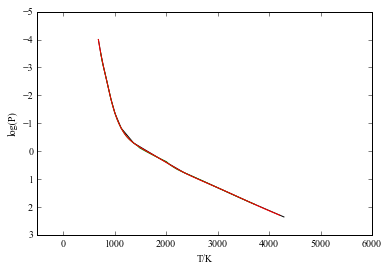

In [22]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-500., 6000.,3.0,-5.0])
plt.plot(prof,logcoarsePress,'k-')
plt.plot(modT,np.log10(modP),'g-')
logP = np.log10(press)
plotT = TPmod.set_prof(proftype,coarsePress,press,prof)
plt.plot(plotT,logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('T/K')


In [14]:
LP = testkit.lnprob(theta,*runargs) #* -2. / (obspec.shape[1] /3.)
#print testkit.lnprob(theta2,*runargs) * -2. / (obspec.shape[1] /3.)
print LP

a1 =  0.383779
a2 =  0.1426819
P1 =  -1.38477798
P3 =  2.2469414
T3 =  4386.998
T =  [  710.33478778   711.96009926   714.00224303   716.51588538   719.55153005
   723.15402353   727.36164254   732.20540389   737.70965571   743.89241484
   750.76593334   758.33722077   766.60830953   775.57615214   785.23214706
   795.56144088   806.54234722   818.1464316    830.33998972   843.08771482
   856.35922388   870.13872811   884.43748607   899.30788689   914.85721585
   931.25864101   948.75696659   967.66728574   988.36580391  1011.27353783
  1036.83496154  1065.49460749  1097.67489838  1133.75804335  1174.07384551
  1218.89403468  1268.43258611  1322.85066267  1382.26443885  1446.75410503
  1516.37268671  1591.15378501  1671.11781078  1756.27394633  1846.62313478
  1942.15937126  2042.86565963  2148.70738286  2259.62092403  2375.49517434
  2496.14582449  2621.28055461  2750.45608156  2883.03025874  3018.11545611
  3154.54259079  3290.84733855  3425.29005021  3555.91778408  3680.67042423
  3

In [15]:
#len(pickle.dumps([theta,runargs], -1)) / 1e9

In [ ]:
#for gas in range (0,ngas):
##    test= pickle.load( open(lists[gas], "rb" ) )[3]
#    test[np.isnan(test)] = 1.0
#    print test[np.where(np.less(test,0))]
print cloudprof.shape

In [ ]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([-8., 2.,3.0,-5.0])
logP = np.log10(press)
plt.plot(np.log10(cloudprof[0,:,0]),logP, "r-")

plt.ylabel(r'log(P)')
plt.xlabel('log10(dtau)')

In [ ]:
import forwardmodel
print forwardmodel.marv.__doc__